# Amazon Review Trends for each Products Notebook

## Defining the Libraries Needed

In [4]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import pandas as pd
import numpy as np
from selenium import webdriver

## Amazon Laptop Scrapper Code

The following codes are used to scrap the laptop details and links from amazon as per the user's input.

In [4]:
def amazon_content_scraper(inp):
    date=pd.Timestamp.now().strftime("%m/%d/%Y/%H/%M/%S")
    hdf=pd.HDFStore(r'C:\Users\jpravijo\Desktop\Anaconda\amazon_laptops.h5')
    i='+'.join(inp.split())
    search=inp.split()[0]
    '''
    url = 'https://www.amazon.in/s?k='+ i + '&ref=nb_sb_noss' 
    html=urlopen(url)
    
'''
    site = 'https://www.amazon.in/s?k='+ i + '&ref=nb_sb_noss' 
    hdr = {'User-Agent': 'Mozilla/5.0'}
    url = Request(site,headers=hdr)
    html=urlopen(url)

    
    soup=BeautifulSoup(html,'lxml')
    laptop_name=[]
    link=[]
    price =[]
    for index,content in enumerate(soup.find_all('div', class_='sg-col-4-of-12 sg-col-8-of-16 sg-col-16-of-24 sg-col-12-of-20 sg-col-24-of-32 sg-col sg-col-28-of-36 sg-col-20-of-28')):
        if (index<50):
            try:
                #Laptop names
                laptop_names=content.a.text.strip()
                laptop_name.append(laptop_names)
                #laptop_name.append(' '.join(laptop_names.split()[:5]))
                
                #Laptop_links
                link.append('https://www.amazon.in/' + content.a['href'])
                
                try:
                #laptop prices
                    prices=content.find('a',class_='a-size-base a-link-normal s-no-hover a-text-normal').text.split('\n')
                    price.append(prices[1].split('₹')[1])
                except:
                    price.append('Not Found')
            except:
                 pass
        else:
            break
    dic={'laptop names': laptop_name,'Laptop links':link, 'price': price}
    data=pd.DataFrame(dic)
    final_data = data[data['laptop names'].str.contains(search, case=False)].set_index('laptop names').reset_index()
    hdf.put(inp+ '_'+ date, final_data, format='table', data_columns=True);
    hdf.close()
    return final_data

In [ ]:
inp=input('enter the laptop product to find information from amazon: ')
data=amazon_content_scraper(inp);

Storing the data in HDF5 format for future use

In [ ]:
hdf=pd.HDFStore(r'C:\Users\jpravijo\Desktop\Anaconda\amazon_laptops.h5')
hdf.keys()

In [ ]:
data=hdf.get('/lenovo laptops_07/05/2020/15/28/26')

## Laptop Review Scrapper Code

The Following codes are used to scrap the review comments and ratings of each laptop (from the links collected above) from amazon

In [ ]:
def laptop_review_scraper(site):
    
    '''
    hdr = {'User-Agent': 'Mozilla/5.0'}
    url = Request(site,headers=hdr)
    html=urlopen(url)
    '''
    driver = webdriver.Chrome(executable_path=r'C:\Users\jpravijo\Desktop\Anaconda\chromedriver_win32 (2)\chromedriver.exe')
    driver.get(site)
    html = driver.page_source
    soup_content=BeautifulSoup(html,'lxml')
    
    count=0
    reviews_by_customers,rating_precentages='',''
    k=[]
    try:
    #First Group
        average_percentage=soup_content.find('div', id='averageCustomerReviews')
        overall_averaged_precentage=float((average_percentage.a.text).split()[0])
    except:
        overall_averaged_precentage= 'Not Found'
    
    
    #Second Group
    try:
        for j, content_1 in enumerate (soup_content.find_all('div', class_='a-row a-spacing-small review-data')):                            
            reviews_by_customers+=content_1.find('div',class_='a-expander-content reviewText review-text-content a-expander-partial-collapse-content').text
            count
    except:
        reviews_by_customers='Not Found'
        
        
    try:
        precent = soup_content.find('div', class_='a-fixed-left-grid a-spacing-none')
        for i,content_2 in enumerate(precent.find_all('a',class_='a-link-normal')):
            k.append(content_2.text.strip())
        rating_precentages='% '.join((' '.join(k)).split('%'))  
    except:
        rating_precentages='Not Found'
        
    driver.close()
    return overall_averaged_precentage, reviews_by_customers, rating_precentages, count

In [ ]:
o_a_percentage, cust_review, o_a_ratings= [],[],[]
for i in range(data.shape[0]):
    site=data.loc[i, 'Laptop links']
    overall_averaged_precentage, reviews_by_customers, rating_precentages, count = laptop_review_scraper(site)
    o_a_percentage.append(overall_averaged_precentage)
    cust_review.append(reviews_by_customers)
    o_a_ratings.append(rating_precentages)

dic={'OverallPercentage':o_a_percentage, 'CustomerReview':cust_review, 'OverallRatings': o_a_ratings}
df_review=pd.DataFrame(dic)
df_review.head(20)

Storing the data in HDF5 format for future use

In [ ]:
hdf=pd.HDFStore(r'C:\Users\jpravijo\Desktop\Anaconda\Laptop_Review.h5')
date=pd.Timestamp.now().strftime("%m/%d/%Y")
hdf.put(key=, value=df_review, data_columns=True)

In [ ]:
hdf=pd.HDFStore(r'C:\Users\jpravijo\Desktop\Anaconda\Laptop_Review.h5')
hdf.keys()

## Making a single dataframe

In [122]:
hdf=pd.HDFStore(r'C:\Users\jpravijo\Desktop\Anaconda\Laptop_Review.h5')
keys=hdf.keys()
review, laptop_name, rating = [], [], []
for i in keys:
    merge_review = ''
    
    hdf = pd.HDFStore(r'C:\Users\jpravijo\Desktop\Anaconda\Laptop_Review.h5')
    merge_data = hdf.get(i)
    merge_data['OverallPercentage'] = pd.to_numeric(merge_data['OverallPercentage'], errors='coerce')
   
    rating.append(merge_data['OverallPercentage'].mean())
    laptop_name.append(''.join(i.split('/')).split('_')[0])
    
    for j in merge_data.loc[:,'CustomerReview']:
        merge_review+=j
    review.append(merge_review)
    
dic={'Laptop_Company':laptop_name, 'Average Ratings':rating, 'Reviews':review}
Combined_Dataset=pd.DataFrame(dic).drop(index=[3,6,7]).set_index('Laptop_Company').reset_index() #to drop the zenbook alone
Combined_Dataset.loc[5,'Laptop_Company']='Lenovo'
Combined_Dataset.head(10)

,Laptop_Company,Average Ratings,Reviews
0,Acer,3.635714,\nIt's a good product for basic college ND off...
1,Apple,4.333333,\nOkay. So you have been seeing people display...
2,Asus,4.018750,\nEarly review ( used for 4 days)I've been usi...
3,Dell,3.362500,"\nReceived 1year old laptop, so requested for ..."
4,Hp,3.793750,"\nThe name and quality of HP, 1 TB HDD, 4 gb R..."
5,Lenovo,3.320000,"\nVery slow processor, very very laggy... This..."


In [123]:
Combined_Dataset.to_pickle(r'C:\Users\jpravijo\Desktop\Anaconda\Final_Data.pkl')

## EDA

In [124]:
import spacy
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load('en_core_web_sm')

In [125]:
EDA_data=pd.read_pickle(r'C:\Users\jpravijo\Desktop\Anaconda\Final_Data.pkl')
EDA_data['Review_Length']=EDA_data['Reviews'].apply(lambda x: len(x))
EDA_data['Review_1']=EDA_data['Reviews'].apply(lambda x: ' ' .join(x.lower().split('.')))

data=[]
for i in range(EDA_data.shape[0]):
    doc=nlp(EDA_data.iloc[i,4])
    l=[word.lemma_ for word in doc if not word.is_stop|word.is_punct|word.is_space| word.is_digit]
    data.append(' '.join([second_word for second_word in l if second_word.isalnum()]))
EDA_data['Review_1'] = data
EDA_data['Review_Length_1']=EDA_data['Review_1'].apply(lambda x: len(x))

EDA_data.head(10)

,Laptop_Company,Average Ratings,Reviews,Review_Length,Review_1,Review_Length_1
0,Acer,3.635714,\nIt's a good product for basic college ND off...,28319,good product basic college nd office work lapt...,16452
1,Apple,4.333333,\nOkay. So you have been seeing people display...,16798,okay see people display macbook fancy own prem...,9220
2,Asus,4.018750,\nEarly review ( used for 4 days)I've been usi...,52066,early review dell year hp acer lenovo laptop p...,29479
3,Dell,3.362500,"\nReceived 1year old laptop, so requested for ...",36770,receive 1year old laptop request replacement 3...,20141
4,Hp,3.793750,"\nThe name and quality of HP, 1 TB HDD, 4 gb R...",59666,quality hp tb hdd gb ram late 9th generation a...,32790
5,Lenovo,3.320000,"\nVery slow processor, very very laggy... This...",45775,slow processor laggy laptop laptop display poo...,25676


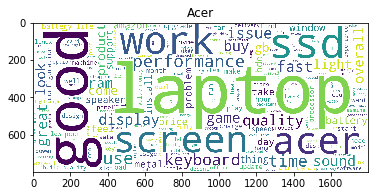

In [126]:
plt.title('Acer')
plt.imshow(wordcloud.WordCloud(width=1800, height=800, background_color='white', min_font_size=10).generate(EDA_data.loc[0, 'Review_1']))

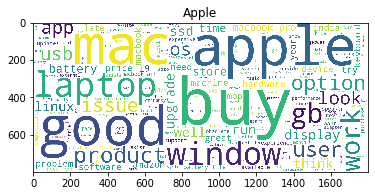

In [127]:
plt.title('Apple')
plt.imshow(wordcloud.WordCloud(width=1800, height=800, background_color='white', min_font_size=10).generate(EDA_data.loc[1, 'Review_1']))

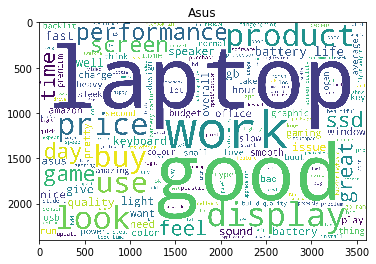

In [128]:
plt.title('Asus')
plt.imshow(wordcloud.WordCloud(width=3600, height=2400, background_color='white', min_font_size=10).generate(EDA_data.loc[2, 'Review_1']))

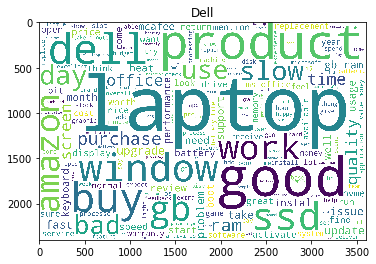

In [129]:
plt.title('Dell')
plt.imshow(wordcloud.WordCloud(width=3600, height=2400, background_color='white', min_font_size=10).generate(EDA_data.loc[3, 'Review_1']))

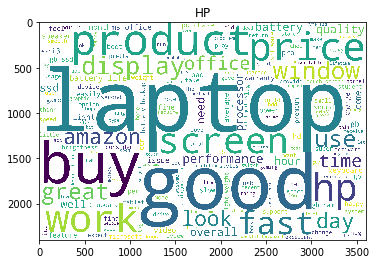

In [130]:
plt.title('HP')
plt.imshow(wordcloud.WordCloud(width=3600, height=2400, background_color='white', min_font_size=10).generate(EDA_data.loc[4, 'Review_1']))

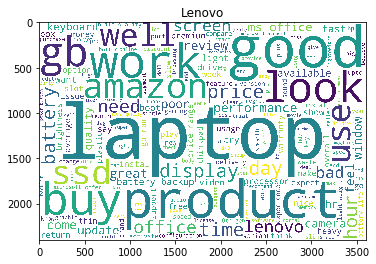

In [131]:
plt.title('Lenovo')
plt.imshow(wordcloud.WordCloud(width=3600, height=2400, background_color='white', min_font_size=10).generate(EDA_data.loc[5, 'Review_1']))

<b> TextBlob Sentiment Analysis</b>

In [132]:
count, final_word, final_lis=0,[], []
threshold=0
for o in range(EDA_data.shape[0]):
    lis, word = [],[]
    for i in EDA_data.loc[o,'Review_1'].split():
        j=TextBlob(i).sentiment[0]
        if j!=threshold:
            lis.append(j)
            word.append(i)
            count+=1
    final_word.append(' '.join(word))
    final_lis.append(np.asarray(lis).mean())

EDA_data['TextBlob_Final_Words']=final_word
EDA_data['TextBlob_Sentiment_Result']=final_lis
EDA_data.head()

,Laptop_Company,Average Ratings,Reviews,Review_Length,Review_1,Review_Length_1,TextBlob_Final_Words,TextBlob_Sentiment_Result
0,Acer,3.635714,\nIt's a good product for basic college ND off...,28319,good product basic college nd office work lapt...,16452,good good sound good good good educational lig...,0.232733
1,Apple,4.333333,\nOkay. So you have been seeing people display...,16798,okay see people display macbook fancy own prem...,9220,okay own late great little cozy jail real good...,0.265533
2,Asus,4.018750,\nEarly review ( used for 4 days)I've been usi...,52066,early review dell year hp acer lenovo laptop p...,29479,early past amazing vital smooth awesome smart ...,0.260727
3,Dell,3.362500,"\nReceived 1year old laptop, so requested for ...",36770,receive 1year old laptop request replacement 3...,20141,old ok great mean genuine past bad pretty good...,0.165974
4,Hp,3.793750,"\nThe name and quality of HP, 1 TB HDD, 4 gb R...",59666,quality hp tb hdd gb ram late 9th generation a...,32790,late fast good good cheap perfect cheap love s...,0.289667


<b> Vader Sentiment Analysis</b>

In [133]:
final_word, final_lis=[], []
for o in range(EDA_data.shape[0]):
    count, neg_lis, pos_lis, word = 0, [], [], []
    for i in EDA_data.loc[o,'Review_1'].split():
        neg=SentimentIntensityAnalyzer().polarity_scores(i)['neg']
        pos=SentimentIntensityAnalyzer().polarity_scores(i)['pos']
        if neg==0 and pos==0:
            pass
        else:
            count+=1
            word.append(i)
            neg_lis.append(neg)
            pos_lis.append(pos)
    final_word.append(' '.join(word))
    final_lis.append((sum(pos_lis)-sum(neg_lis))/count)
EDA_data['Vader_Final_Words']=final_word
EDA_data['Vader_Sentiment_Result']=final_lis
EDA_data.drop(['Review_1', 'Review_Length_1'],axis=1, inplace=True)
EDA_data.head()

,Laptop_Company,Average Ratings,Reviews,Review_Length,TextBlob_Final_Words,TextBlob_Sentiment_Result,Vader_Final_Words,Vader_Sentiment_Result
0,Acer,3.635714,\nIt's a good product for basic college ND off...,28319,good good sound good good good educational lig...,0.232733,good good low good good problem good thank han...,0.491184
1,Apple,4.333333,\nOkay. So you have been seeing people display...,16798,okay own late great little cozy jail real good...,0.265533,okay amazon stop support feeling improve obsol...,0.525862
2,Asus,4.018750,\nEarly review ( used for 4 days)I've been usi...,52066,early past amazing vital smooth awesome smart ...,0.260727,surprise amazing play vital awesome smart orig...,0.593838
3,Dell,3.362500,"\nReceived 1year old laptop, so requested for ...",36770,old ok great mean genuine past bad pretty good...,0.165974,ok amazon cancel great fool restriction like p...,0.383948
4,Hp,3.793750,"\nThe name and quality of HP, 1 TB HDD, 4 gb R...",59666,late fast good good cheap perfect cheap love s...,0.289667,good mistake good perfect love easy hope well ...,0.573604


## Final Result

<b> Review Taken from Amazon </b>

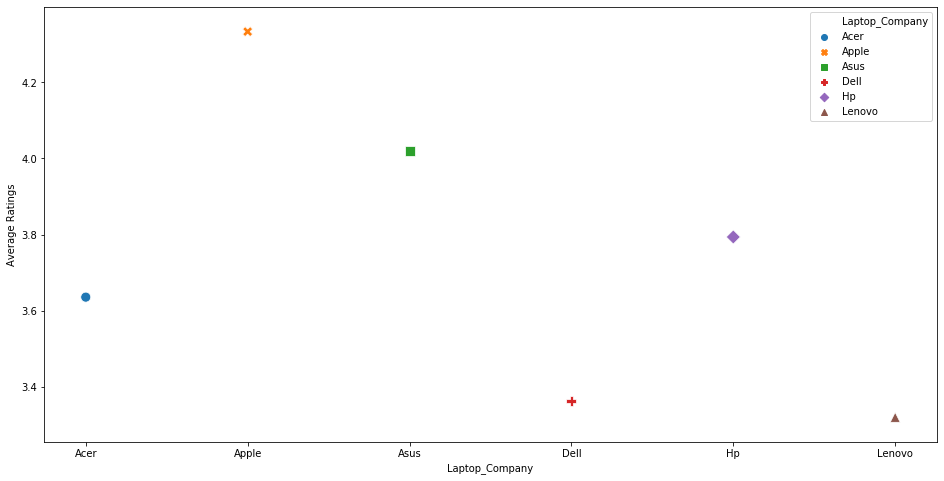

In [134]:
fig=plt.figure(figsize=(16,8))
ax=fig.gca()
sns.scatterplot(data=EDA_data, x=EDA_data.Laptop_Company, y='Average Ratings', hue='Laptop_Company',ax=ax, style='Laptop_Company',s=100)

<b> Textblob Sentiment Analysis Report </b>

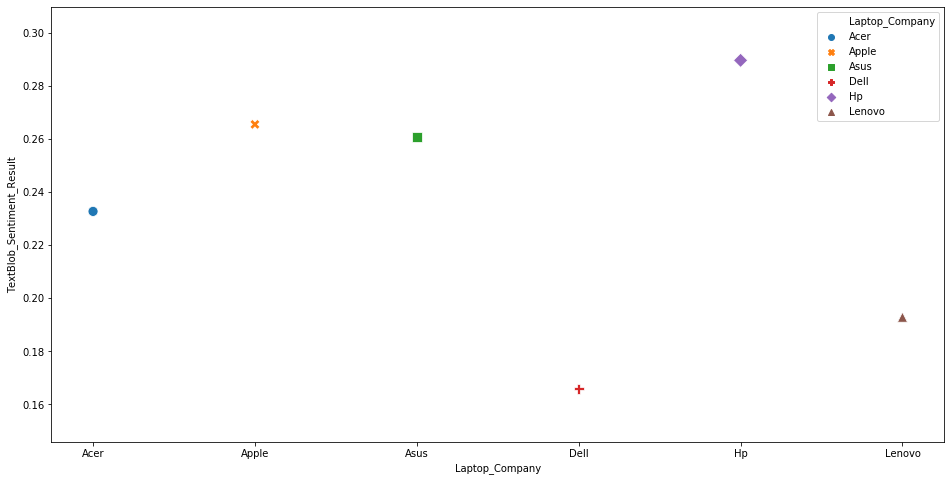

In [135]:
fig=plt.figure(figsize=(16,8))
ax=fig.gca()
sns.scatterplot(data=EDA_data, x=EDA_data.Laptop_Company, y='TextBlob_Sentiment_Result', hue='Laptop_Company',ax=ax, style='Laptop_Company',s=100)

<b> Vader Sentiment Analysis Report </b>

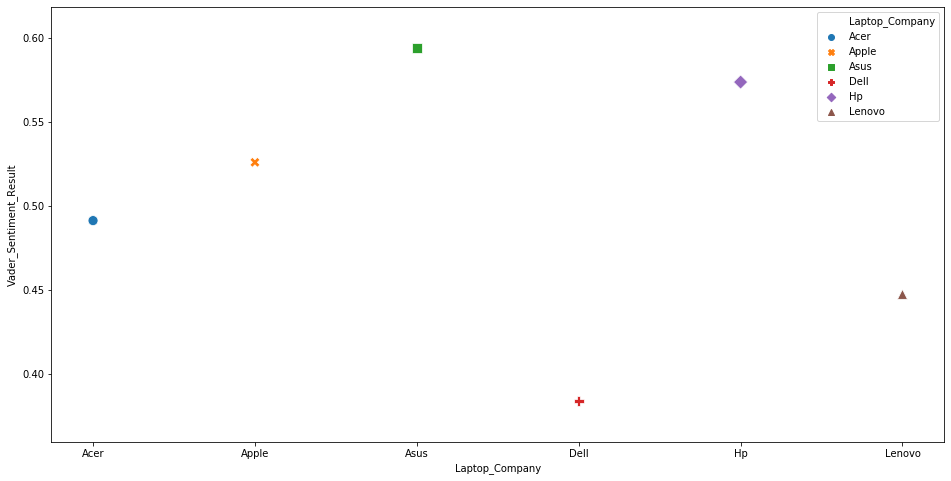

In [136]:
fig=plt.figure(figsize=(16,8))
ax=fig.gca()
sns.scatterplot(data=EDA_data, x=EDA_data.Laptop_Company, y='Vader_Sentiment_Result', hue='Laptop_Company',ax=ax, style='Laptop_Company',s=100)

<b> Final DataFrame </b>

In [137]:
EDA_data.head(10)

,Laptop_Company,Average Ratings,Reviews,Review_Length,TextBlob_Final_Words,TextBlob_Sentiment_Result,Vader_Final_Words,Vader_Sentiment_Result
0,Acer,3.635714,\nIt's a good product for basic college ND off...,28319,good good sound good good good educational lig...,0.232733,good good low good good problem good thank han...,0.491184
1,Apple,4.333333,\nOkay. So you have been seeing people display...,16798,okay own late great little cozy jail real good...,0.265533,okay amazon stop support feeling improve obsol...,0.525862
2,Asus,4.018750,\nEarly review ( used for 4 days)I've been usi...,52066,early past amazing vital smooth awesome smart ...,0.260727,surprise amazing play vital awesome smart orig...,0.593838
3,Dell,3.362500,"\nReceived 1year old laptop, so requested for ...",36770,old ok great mean genuine past bad pretty good...,0.165974,ok amazon cancel great fool restriction like p...,0.383948
4,Hp,3.793750,"\nThe name and quality of HP, 1 TB HDD, 4 gb R...",59666,late fast good good cheap perfect cheap love s...,0.289667,good mistake good perfect love easy hope well ...,0.573604
5,Lenovo,3.320000,"\nVery slow processor, very very laggy... This...",45775,slow poor single average bad old fast waste wo...,0.192865,poor like bad trust thank waste worst amazon s...,0.447323


Conclusion:
- We have successfully analysed the sentiment of the laptop reviews from the amazon. Apple, Asus, HP stands Top in one of the three different analysis shown above.